In [6]:
import csv
import glob
import torch
import random
import copy
import numpy as np
import SimpleITK as sitk
from scipy.special import comb
from matplotlib import pyplot as plt
from pathlib import Path
from tqdm import tqdm_notebook as tqdm

In [9]:
train_subset = ['subset0', 'subset1', 'subset7', 'subset8']
data_dir = Path('/home/tony/datasets/LUNA')
for _set in train_subset:
    _dir = data_dir / Path(_set)
    img3d_paths = list(_dir.glob('*.mhd'))
    print(len(img3d_paths))
# for p in img_paths:
#     img = normalizePlanes(load_itk_image(str(p)))
#     print(img.shape)

89
89
89
88


In [3]:
def load_itk_image(path):
    itkimage = sitk.ReadImage(path)
    numpyImage = sitk.GetArrayFromImage(itkimage)
    return numpyImage
     
def hu_normalize(img_array, hu_max, hu_min):
    # HU_thred = (-150.0 - hu_min) / (hu_max - hu_min)
    img_array[img_array < hu_min] = hu_min
    img_array[img_array > hu_max] = hu_max
    img_array = 1.0*(img_array-hu_min) / (hu_max-hu_min)
    return img_array

def normalizePlanes(npzarray):
     
    maxHU = 1000.
    minHU = -1000.
 
    npzarray = (npzarray - minHU) / (maxHU - minHU)
    npzarray[npzarray>1] = 1.
    npzarray[npzarray<0] = 0.
    return npzarray

(280, 512, 512)


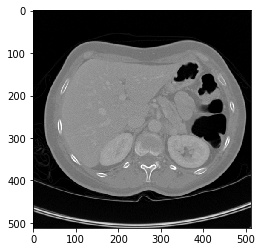

In [4]:
path = str(img_paths[9])
img = load_itk_image(path)
img = normalizePlanes(img)
print(img.shape)
img = img[5]
img = np.stack((img, img, img), 2)
plt.imshow(img)

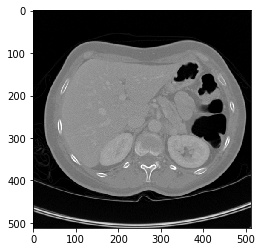

In [40]:
path = str(img_paths[9])
img = load_itk_image(path)
img = hu_normalize(img, 1000.0, -1000.0)
img = img[5]
img = np.stack((img, img, img), 2)
plt.imshow(img)

In [171]:
def _image_in_painting(x):
    img_rows, img_cols, img_deps = x.shape
    cnt = 5
    while cnt > 0 and random.random() < 0.95:
        block_noise_size_x = random.randint(img_rows//6, img_rows//3)
        block_noise_size_y = random.randint(img_cols//6, img_cols//3)
        block_noise_size_z = random.randint(img_deps//6, img_deps//3)
        noise_x = random.randint(3, img_rows-block_noise_size_x-3)
        noise_y = random.randint(3, img_cols-block_noise_size_y-3)
        noise_z = random.randint(3, img_deps-block_noise_size_z-3)
        print(f'{noise_x}, {noise_y}, {noise_z}')
        x[noise_x:noise_x+block_noise_size_x, 
          noise_y:noise_y+block_noise_size_y, 
          noise_z:noise_z+block_noise_size_z] = np.random.rand(block_noise_size_x, 
                                                               block_noise_size_y, 
                                                               block_noise_size_z, ) * 1.0
        cnt-=1
    return x

def _image_out_painting(x):
    img_rows, img_cols, img_deps = x.shape
    image_temp = copy.deepcopy(x)
    x = np.random.rand(x.shape[0], x.shape[1], x.shape[2]) * 1.0
    block_noise_size_x = img_rows - random.randint(3*img_rows//7, 4*img_rows//7)
    block_noise_size_y = img_cols - random.randint(3*img_cols//7, 4*img_cols//7)
    block_noise_size_z = img_deps - random.randint(3*img_deps//7, 4*img_deps//7)
    noise_x = random.randint(3, img_rows-block_noise_size_x-3)
    noise_y = random.randint(3, img_cols-block_noise_size_y-3)
    noise_z = random.randint(3, img_deps-block_noise_size_z-3)
    x[noise_x:noise_x+block_noise_size_x, 
      noise_y:noise_y+block_noise_size_y, 
      noise_z:noise_z+block_noise_size_z] = image_temp[noise_x:noise_x+block_noise_size_x, 
                                                       noise_y:noise_y+block_noise_size_y, 
                                                       noise_z:noise_z+block_noise_size_z]
    cnt = 15
    while cnt > 0:
        block_noise_size_x = img_rows - random.randint(3*img_rows//7, 4*img_rows//7)
        block_noise_size_y = img_cols - random.randint(3*img_cols//7, 4*img_cols//7)
        block_noise_size_z = img_deps - random.randint(3*img_deps//7, 4*img_deps//7)
        noise_x = random.randint(3, img_rows-block_noise_size_x-3)
        noise_y = random.randint(3, img_cols-block_noise_size_y-3)
        noise_z = random.randint(3, img_deps-block_noise_size_z-3)
        x[noise_x:noise_x+block_noise_size_x, 
          noise_y:noise_y+block_noise_size_y, 
          noise_z:noise_z+block_noise_size_z] = image_temp[noise_x:noise_x+block_noise_size_x, 
                                                           noise_y:noise_y+block_noise_size_y, 
                                                           noise_z:noise_z+block_noise_size_z]
        cnt-=1
    return x

218, 133, 9
179, 203, 4
276, 159, 9
134, 163, 4
229, 91, 4


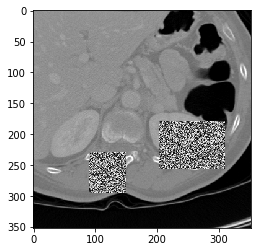

In [180]:
path = str(img_paths[9])
img = load_itk_image(path)
img = hu_normalize(img, 1000.0, -1000.0)
img = img[5, 128:480, 128:480]
img_3d = np.stack((img, img, img, img, img, img, img, img, img, img, img, img, img, img, img, img), 2)
img_3d = _image_in_painting(img_3d)
img_shuffle = img_3d[:, :, 6]
img_shuffle = np.stack((img_shuffle, img_shuffle, img_shuffle), 2)
plt.imshow(img_shuffle)

In [174]:
img_3d.shape

(352, 352, 16)

In [91]:
img.shape

(512, 512, 3)